In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset, num2date
import pandas as pd
from glob import glob
from datetime import datetime, timedelta
from scipy.ndimage import binary_dilation, maximum_filter
from util.ContingencyTable import ContingencyTable as CT
from hagelslag.util.make_proj_grids import read_ncar_map_file, make_proj_grids
import cPickle
from hagelslag.evaluation.ProbabilityMetrics import DistributedCRPS, DistributedROC, DistributedReliability, bootstrap
from hagelslag.evaluation.MetricPlotter import performance_diagram, attributes_diagram
from hagelslag.util.make_proj_grids import read_arps_map_file
from skimage.morphology import disk
import matplotlib as mpl
from sklearn.tree import export_graphviz
from scipy.stats import gamma, genextreme

In [6]:
member_info = pd.read_csv("/sharp/djgagne/member_info_ssef_spring2015.csv", index_col="Ensemble_Member")
#member_info = pd.read_csv("/sharp/djgagne/member_info_ncar_2015.csv", index_col="Ensemble_Member")
member_info

,IC,BC,Microphysics,LSM,PBL,MicrophysicsTrue
Ensemble_Member,,,,,,
wrf-s3cn_arw,00Z ARPSa,00Z NAMf,Thompson,Noah,MYJ,Thompson
wrf-s3m3_arw,arw_cn+em-p1_pert,21Z SREF em-p1,MY,Noah,MYNN,P3
wrf-s3m4_arw,arw_cn+em-n2_pert,21Z SREF em-n2,MY,Noah,YSU,MY
wrf-s3m5_arw,arw_cn+nmm-p1_pert,21Z SREF nmm-p1,Morrison,Noah,MYNN,Morrison
wrf-s3m6_arw,arw_cn+nmmb-n1_pert,21Z SREF nmmb-n1,MY,Noah,MYJ,MY
wrf-s3m7_arw,arw_cn-nmmb_p1_pert,21Z SREF nmmb-p1,MY,Noah,YSU,P3
wrf-s3m8_arw,arw_cn-em-n1_pert,21Z SREF em-n1,MY,Noah,MYJ,P3
wrf-s3m9_arw,arw_cn-em-p2_pert,21Z SREF em-p2,MY,Noah,MYNN,MY
wrf-s3m10_arw,arw_cn-nmmb-n3_pert,21Z SREF nmmb-n3,Morrison,Noah,YSU,Morrison


In [102]:
def load_mrms(start_date, end_date, variable, path="/sharp/djgagne/mrms_spring2015//"):
    all_dates = pd.DatetimeIndex(start=start_date, end=end_date, freq="1H")
    data_files = np.array(sorted(glob(path + variable + "/*.nc")))
    data_file_dates = np.array([df.split("/")[-1][len(variable)+1:len(variable)+9] for df in data_files])
    curr_date = None
    prev_date = None
    ds = None
    data = []
    for date in all_dates:
        print date
        curr_date = date.date().strftime("%Y%m%d")
        if curr_date != prev_date:
            if prev_date is not None:
                ds.close()
            filename = data_files[curr_date == data_file_dates][0]
            ds = Dataset(filename)
            var_times = num2date(ds.variables["time"][:], ds.variables["time"].units)
        ti = np.where(var_times == date)[0]
        data.append(ds.variables[variable][ti][0])
    return np.array(data)
run_date = datetime(2015,6,1)            
start_date = run_date + timedelta(hours=12)          
mrms_data = load_mrms(start_date, start_date + timedelta(hours=24),"MESH_Max_60min_00.50")
#rqi_data = load_mrms(start_date, start_date + timedelta(hours=24), "RadarQualityIndex_00.00")

2015-06-01 12:00:00
2015-06-01 13:00:00
2015-06-01 14:00:00
2015-06-01 15:00:00
2015-06-01 16:00:00
2015-06-01 17:00:00
2015-06-01 18:00:00
2015-06-01 19:00:00
2015-06-01 20:00:00
2015-06-01 21:00:00
2015-06-01 22:00:00
2015-06-01 23:00:00
2015-06-02 00:00:00
2015-06-02 01:00:00
2015-06-02 02:00:00
2015-06-02 03:00:00
2015-06-02 04:00:00
2015-06-02 05:00:00
2015-06-02 06:00:00
2015-06-02 07:00:00
2015-06-02 08:00:00
2015-06-02 09:00:00
2015-06-02 10:00:00
2015-06-02 11:00:00
2015-06-02 12:00:00


In [7]:
proj_dict, grid_dict = read_arps_map_file("/home/djgagne/hagelslag/mapfiles/ssef2015.map")
print proj_dict
print grid_dict
proj_dict["rsphere"] = proj_dict["a"]
del proj_dict["a"]
del proj_dict["b"]
del proj_dict["proj"]
del proj_dict["units"]
bmap = Basemap(llcrnrlon=grid_dict["sw_lon"], llcrnrlat=grid_dict["sw_lat"], urcrnrlon=grid_dict["ne_lon"],
               urcrnrlat=grid_dict["ne_lat"], resolution="l", projection="lcc",**proj_dict)
ssef_map_grid = Dataset("/sharp/djgagne/ssef_2015_grid.nc")
print ssef_map_grid.variables.keys()
x = ssef_map_grid.variables["x"][:]
y = ssef_map_grid.variables["y"][:]
ssef_map_grid.close()

{'a': 6370000.0, 'b': 6370000.0, 'lon_0': -97.0, 'proj': 'lcc', 'units': 'm', 'lat_2': 60.0, 'lat_1': 30.0, 'lat_0': 38.50001}
{'sw_lon': -120.0759, 'ne_lon': -59.89298, 'dx': 3000.0, 'dy': 3000.0, 'sw_lat': 19.78931, 'ne_lat': 49.05653}
[u'lon', u'lat', u'x', u'y', u'i', u'j']


In [5]:
proj_dict, grid_dict = read_ncar_map_file("/home/djgagne/hagelslag/mapfiles/ncar_ensemble_map_2015.txt")
mapping_data = make_proj_grids(proj_dict, grid_dict)
bmap = Basemap(projection='lcc', resolution='l', lon_0=-101, lat_0=39, lat_1=32, lat_2=46,
               llcrnrlon=mapping_data['lon'][0,0], urcrnrlon=mapping_data['lon'][-1,-1],
               llcrnrlat=mapping_data['lat'][0,0], urcrnrlat=mapping_data['lat'][-1,-1]
              )
x, y= bmap(mapping_data['lon'], mapping_data['lat'])


In [5]:
def make_proj_grids_ipy(proj_dict, grid_dict):
    map_proj = Proj(proj_dict)
    sw_x, sw_y = map_proj(grid_dict['sw_lon'], grid_dict['sw_lat'])
    ne_x, ne_y = map_proj(grid_dict['ne_lon'], grid_dict['ne_lat'])
    dx = grid_dict['dx']
    dy = grid_dict['dy']
    if proj_dict['units'] == "m":
        rounding = -2
    else:
        rounding = 0
    print dx, dy, np.round(sw_y, rounding), np.round(ne_y, rounding)
    x = np.arange(np.round(sw_x,rounding), np.round(ne_x,rounding) + dx, dx)
    y = np.arange(np.round(sw_y,rounding), np.round(ne_y,rounding) + dy, dy)
    print x.shape, y.shape
    x_grid, y_grid = np.meshgrid(x, y)
    lon_grid, lat_grid = map_proj(x_grid, y_grid, inverse=True)
    mapping_data = {'lon': lon_grid, 'lat': lat_grid, 'x': x_grid, 'y': y_grid}
    return mapping_data

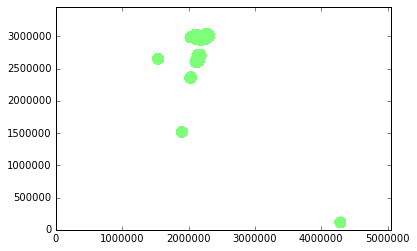

In [103]:
weights = disk(28)
verification = maximum_filter(np.where(mrms_data.max(axis=0)>=50,1,0), footprint=weights)
#rqi_ver = rqi_data.min(axis=0) >= 0.5
plt.contourf(x,y, verification,[0.5,1.5])

In [15]:
run_date = datetime(2015, 11, 16)
consensus_forecasts = {}
for m_var in ["Random-Forest"]:
    print m_var
    rfc = Dataset("/sharp/djgagne/ensemble_consensus_ncar_2015_uh/{1}/{0}_dist_consensus_{1}.nc".format(m_var, run_date.strftime("%Y%m%d")))
    consensus_forecasts[m_var] = rfc.variables["neighbor_prob_25-hour_r_28_s_20_dist_50.00"][:]
    rfc.close()
n_vars = ["neighbor_prob_25-hour_r_28_s_20_UP_HELI_MAX_150.00"]
n_var_names = ["Updraft Helicity"]
f_names = ["UP_HELI_MAX"]
for n, n_var in enumerate(n_vars):
    print n_var
    ens_mod = Dataset("/sharp/djgagne/ensemble_consensus_ncar_2015_uh/{1}/NCAR_{0}_consensus_{1}.nc".format(f_names[n], run_date.strftime("%Y%m%d")))
    consensus_forecasts[n_var_names[n]] = ens_mod.variables[n_var][:]
    ens_mod.close()

Random-Forest
neighbor_prob_25-hour_r_28_s_20_UP_HELI_MAX_150.00


In [100]:
run_date = datetime(2015, 6, 1)
consensus_forecasts = {}
#consensus_dir = "/sharp/djgagne/ensemble_consensus_ssef_cqg_closest_2015/"
consensus_dir = "/sharp/djgagne/hail_consensus_gbr_ssef_cqg_closest_2015/"
for m_var in ["Random-Forest-CV", "Elastic-Net"]:
    print m_var
    filename = consensus_dir + "{1}/SSEF_{0}_dist_consensus_{1}.nc".format(m_var, run_date.strftime("%Y%m%d"))
    print filename
    rfc = Dataset(filename)
    print rfc.variables.keys()
    consensus_forecasts[m_var] = rfc.variables["neighbor_prob_25-hour_r_28_s_20_dist_50.00"][:]
    rfc.close()

n_vars = ["neighbor_prob_25-hour_r_28_s_20_uh_max_150.00", "neighbor_prob_25-hour_r_28_s_20_hailsz_50.00"]
n_var_names = ["Updraft Helicity", "HAILCAST"]
#n_var_names = ["Updraft-Helicity-75", "Max Graupel-25", "Thompson-Hail-25"]
f_names = ["uh_max", "hailsz"]
#f_names = ["UP_HELI_MAX", "GRPL_MAX", "HAIL_MAX2D"]
for n, n_var in enumerate(n_vars):
    print n_var
    filename = consensus_dir + "{1}/SSEF_WRF_{0}_consensus_{1}.nc".format(f_names[n], run_date.strftime("%Y%m%d"))
    print filename
    ens_mod = Dataset(filename)
    consensus_forecasts[n_var_names[n]] = ens_mod.variables[n_var][:]
    ens_mod.close()

Random-Forest-CV
/sharp/djgagne/hail_consensus_gbr_ssef_cqg_closest_2015/20150601/SSEF_Random-Forest-CV_dist_consensus_20150601.nc
[u'time', u'neighbor_prob_r_14_s_5_dist_25.00', u'neighbor_prob_r_14_s_20_dist_25.00', u'neighbor_prob_25-hour_r_14_s_5_dist_25.00', u'neighbor_prob_25-hour_r_14_s_20_dist_25.00', u'neighbor_prob_r_28_s_5_dist_25.00', u'neighbor_prob_r_28_s_20_dist_25.00', u'neighbor_prob_r_14_s_5_dist_50.00', u'neighbor_prob_r_14_s_20_dist_50.00', u'neighbor_prob_r_28_s_5_dist_50.00', u'neighbor_prob_r_28_s_20_dist_50.00', u'neighbor_prob_25-hour_r_28_s_5_dist_25.00', u'neighbor_prob_25-hour_r_28_s_20_dist_25.00', u'neighbor_prob_25-hour_r_14_s_5_dist_50.00', u'neighbor_prob_25-hour_r_14_s_20_dist_50.00', u'neighbor_prob_25-hour_r_28_s_5_dist_50.00', u'neighbor_prob_25-hour_r_28_s_20_dist_50.00']
Elastic-Net
/sharp/djgagne/hail_consensus_gbr_ssef_cqg_closest_2015/20150601/SSEF_Elastic-Net_dist_consensus_20150601.nc
[u'time', u'neighbor_prob_r_14_s_5_dist_25.00', u'neighbor

In [24]:
consensus_forecasts["Random-Forest-CV"].max()

0.14257812

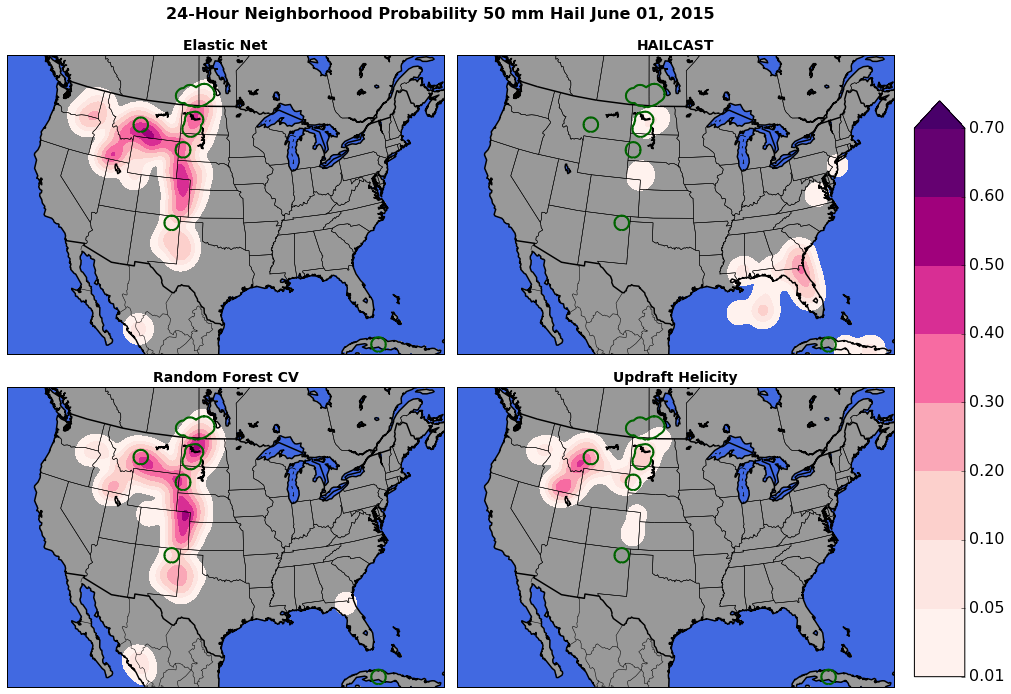

In [104]:
fig = plt.figure(figsize=(14,10))
#fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(0.02,0.02,0.90,0.93,0.03, 0.03)
case_size = 50
for i, k in enumerate(sorted(consensus_forecasts.keys())):
    plt.subplot(2,2,i+1)
    bmap.drawstates()
    bmap.drawcoastlines(linewidth=1.5)
    bmap.drawcountries(linewidth=1.5)
    bmap.drawlsmask(land_color='0.6',ocean_color='royalblue')
    co = plt.contourf(x, y, consensus_forecasts[k], 
                      [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], extend='max', cmap="RdPu")
    plt.contour(x, y, verification, [0.5], colors=['darkgreen'], linewidths=2)
    #plt.colorbar(co, orientation="horizontal", shrink=0.8, fraction=0.15, pad=0.01 )
    plt.title(k.replace("-", " ").replace("_"," "), 
              fontsize=14, fontweight="bold")
cbar_ax = fig.add_axes([0.92, 0.05, 0.05, 0.8])
plt.suptitle("24-Hour Neighborhood Probability {0} mm Hail {1}".format(case_size, run_date.strftime("%B %d, %Y")), 
             fontsize=16, fontweight="bold",
            x=0.45)
cbar = fig.colorbar(co, cax=cbar_ax)
cbar.ax.tick_params(labelsize=16) 
plt.savefig("/sharp/djgagne/hail_figures_ams2016/neighborhood_prob_comp_{0}_50_cqg_closest_gbr.pdf".format(
            run_date.strftime("%Y%m%d")), 
            dpi=300, bbox_inches="tight")

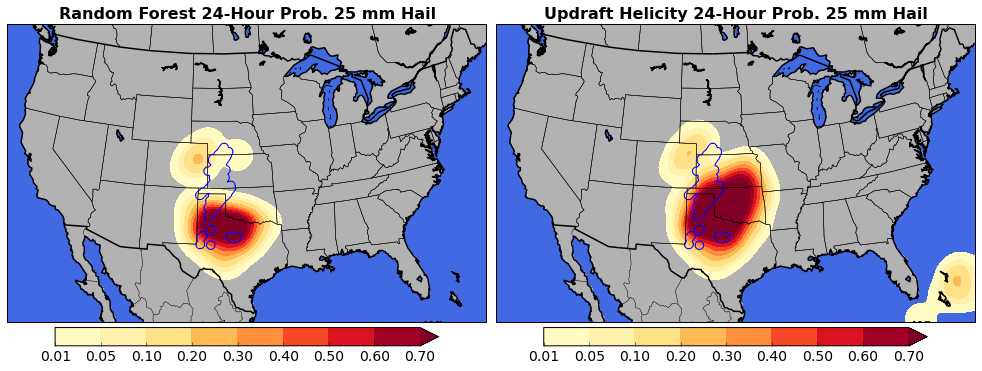

In [66]:
plt.figure(figsize=(14,8))
plt.subplots_adjust(0.02,0.02,0.98,0.95,0.02, 0.02)
for i, k in enumerate(sorted(consensus_forecasts.keys())):
    plt.subplot(1,2,i+1)
    bmap.drawstates()
    bmap.drawcoastlines(linewidth=1.5)
    bmap.drawcountries(linewidth=1.5)
    bmap.drawlsmask(land_color='0.7',ocean_color='royalblue')
    co = plt.contourf(x, y, consensus_forecasts[k], 
                      [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], extend='max', cmap="YlOrRd")
    plt.contour(x, y, verification, [0.5], colors=['blue'])
    cb = plt.colorbar(co, orientation="horizontal", shrink=0.8, fraction=0.15, pad=0.01)
    cb.ax.tick_params(labelsize=14) 
    plt.title(k.replace("-", " ").replace("_"," ") + " 24-Hour Prob. 25 mm Hail", fontsize=16, fontweight="bold")
plt.savefig("/sharp/djgagne/hail_figures_spring2015/ncar_neighborhood_prob_comp_{0}_25_2.png".format(
            run_date.strftime("%Y%m%d")), 
            dpi=300, bbox_inches="tight")

In [149]:
proj_dict

{'a': 6370000.0,
 'b': 6370000.0,
 'lat_0': 39.0,
 'lat_1': 32.0,
 'lat_2': 46.0,
 'lon_0': -101.0,
 'proj': 'lcc',
 'units': 'm'}

In [86]:
#period_eval = pd.read_csv("/sharp/djgagne/neighbor_scores_ssef_unique_2015/ssef_cqg_closest_period_scores.csv",  parse_dates=["Run_Date"])
period_eval = pd.read_csv("/sharp/djgagne/neighbor_scores_ncar_2015/ncar_2015_neighbor_series_period_scores.csv")
print period_eval.shape
period_eval = period_eval.drop(np.where(np.in1d(period_eval['Run_Date'].values, 
                 [np.datetime64('2015-05-16'), np.datetime64('2015-05-18'),
                  np.datetime64('2015-05-23'), np.datetime64('2015-05-24'), np.datetime64('2015-05-30'),
                 np.datetime64('2015-05-31')]))[0])
print period_eval.shape
period_eval = period_eval.sort(columns="Run_Date")
period_eval = period_eval.reset_index(drop=True)

(4032, 9)
(4032, 9)


In [110]:
model_col = period_eval["Model_Name"]  + "_" + period_eval["Forecast_Variable"]
all_models = pd.unique(model_col)
print all_models
smoothing_radius = 20
size_threshold = [50, 150, 40]
neighbor_radius = 28

roc_scores = {}
all_roc_scores = {}
rel_scores = {}
all_rel_scores = {}
for model in all_models:
    idxs = (model_col == model) &\
           (period_eval["Smoothing_Radius"]==smoothing_radius) &\
           (period_eval["Size_Threshold"].isin(size_threshold)) &\
           (period_eval["Neighbor_Radius"]==neighbor_radius)
    if np.count_nonzero(idxs) > 0:
        roc = pd.Series([DistributedROC(input_str=x) for x in period_eval.loc[idxs, "ROC"]], 
                        index=pd.DatetimeIndex(period_eval.loc[idxs, "Run_Date"]))
        rel = pd.Series([DistributedReliability(input_str=x) for x in period_eval.loc[idxs, "Reliability"]],
                        index=pd.DatetimeIndex(period_eval.loc[idxs, "Run_Date"]))
        roc_scores[model] = np.sum(roc)
        rel_scores[model] = np.sum(rel)
        all_roc_scores[model] = roc
        all_rel_scores[model] = rel
        print model, roc_scores[model].auc(), rel_scores[model].brier_skill_score()

['Elastic-Net_dist' 'NCAR_GRPL_MAX' 'NCAR_UP_HELI_MAX'
 'Random-Forest-CV_dist' 'NCAR_HAIL_MAXK1' 'Random-Forest_dist'
 'NCAR_HAIL_MAX2D']
Elastic-Net_dist 0.856006886911 -0.294753258487
NCAR_GRPL_MAX 0.812535277648 -3.34713434854
NCAR_UP_HELI_MAX 0.827982790368 -0.494883920127
Random-Forest-CV_dist 0.856160925154 -0.326961917059
NCAR_HAIL_MAXK1 0.556116827251 -0.0160522432927
Random-Forest_dist 0.850316378864 -0.234563866695
NCAR_HAIL_MAX2D 0.77240205884 -7.32546848743


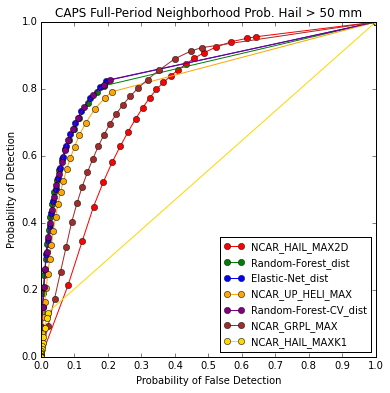

In [88]:
plt.figure(figsize=(6,6))
colors = ['r','g','b','orange', "purple", "brown", "gold"]
c = 0
for model, score in roc_scores.iteritems():
    rc = score.roc_curve()
    plt.plot(rc["POFD"], rc["POD"], marker='o', label=model, color=colors[c])
    c += 1
plt.xlim(0,1)
plt.legend(loc=0, fontsize=10)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Probability of False Detection")
plt.ylabel("Probability of Detection")
plt.title("CAPS Full-Period Neighborhood Prob. Hail > {0:d} mm".format(size_threshold[0]))
#plt.savefig("/sharp/djgagne/neighbor_scores_ssef_unique_2015/roc_full_ssef_2015.png", dpi=300, bbox_inches="tight")

In [92]:
def performance_diagram(roc_objs, obj_labels, colors, markers, filename, figsize=(9, 8), xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, 1.1, 0.1), dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=dict(loc=0, fontsize=12, framealpha=1, frameon=True)):
    """
    Draws a performance diagram from a set of DistributedROC objects.

    :param roc_objs: list or array of DistributedROC Objects.
    :param obj_labels: list or array of labels describing each DistributedROC object.
    :param colors: list of color strings
    :param markers: list of markers.
    :param filename: output filename.
    :param figsize: tuple with size of the figure in inches.
    :param xlabel: Label for the x-axis
    :param ylabel: Label for the y-axis
    :param ticks: Array of ticks used for x and y axes
    :param dpi: DPI of the output image
    :param csi_cmap: Colormap used for the CSI contours
    :param csi_label: Label for the CSI colorbar
    :return:
    """
    plt.figure(figsize=figsize)
    grid_ticks = np.arange(0, 1.01, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, [0,0.05]  + np.arange(0.1, 1.1, 0.1).tolist(), extend="max", cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.1f", manual=[(0.2, 0.9), (0.4, 0.9), (0.6, 0.9), (0.7, 0.7)])
    for r, roc_obj in enumerate(roc_objs):
        perf_data = roc_obj.performance_curve()
        plt.plot(1 - perf_data["FAR"], perf_data["POD"], marker=markers[r], color=colors[r], 
                 label=obj_labels[r].replace("_dist", "").replace("-", " ").replace("_", " "))
    cbar = plt.colorbar(csi_contour)
    cbar.set_label(csi_label, fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.xticks(ticks, fontsize=14)
    plt.yticks(ticks, fontsize=14)
    plt.title(title, fontsize=16, fontweight="bold")
    plt.text(0.48,0.6,"Frequency Bias",fontdict=dict(fontsize=16, rotation=45))
    plt.legend(**legend_params)
    #plt.savefig(filename, dpi=dpi, bbox_inches="tight")


In [ ]:
roc_keys = ['Random-Forest-CV_dist', 'Elastic-Net_dist', "SSEF_uh_max", "SSEF_hailsz", "SSEF_cqgmax"]
roc_vals = [roc_scores[k] for k in roc_keys]
rel_vals = [rel_scores[k] for k in roc_keys]
roc_labels = ["Random Forest", "Elastic Net", "Updraft Helicity", "HAILCAST", "Column Integrated Graupel"]
performance_diagram(roc_vals, roc_labels, ['r','g','orange', 'b', "purple", "teal"], ['o'] *7, 
                    "/sharp/djgagne/hail_figures_ams2016/performance_cqg_{0:d}_{1}.png".format(size_threshold[0], neighbor_radius), 
                    title="24-Hour {1} km Neighbor Prob. of {0:d} mm Hail".format(size_threshold[0], neighbor_radius * 3))

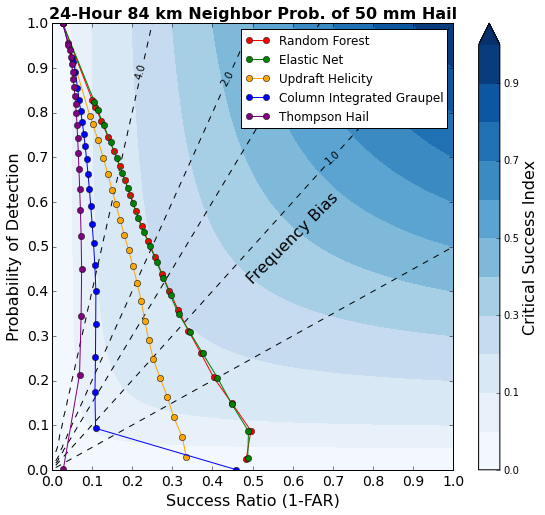

In [111]:
roc_keys = ['Random-Forest-CV_dist', 'Elastic-Net_dist', "NCAR_UP_HELI_MAX", "NCAR_GRPL_MAX", "NCAR_HAIL_MAX2D"]
roc_vals = [roc_scores[k] for k in roc_keys]
rel_vals = [rel_scores[k] for k in roc_keys]
roc_labels = ["Random Forest", "Elastic Net", "Updraft Helicity", "Column Integrated Graupel", "Thompson Hail"]
performance_diagram(roc_vals, roc_labels, ['r','g','orange', 'b', "purple", "teal"], ['o'] *7, 
                    "/sharp/djgagne/hail_figures_ams2016/performance_ncar_{0:d}_{1}.png".format(size_threshold[0], neighbor_radius), 
                    title="24-Hour {1} km Neighbor Prob. of {0:d} mm Hail".format(size_threshold[0], neighbor_radius * 3))

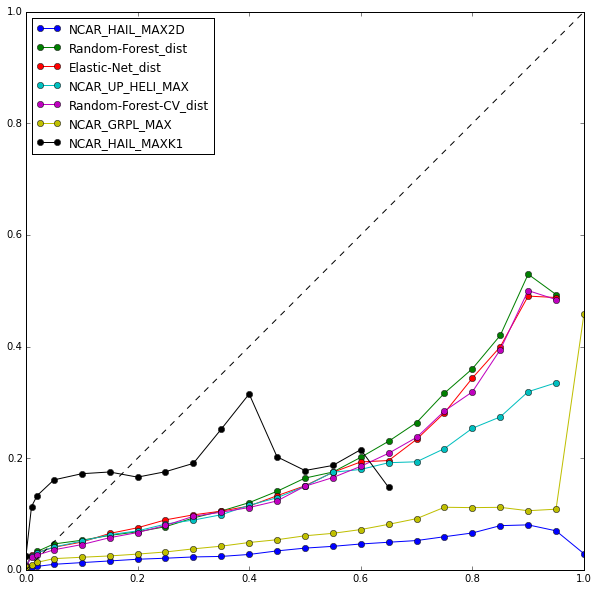

In [112]:
plt.figure(figsize=(10, 10))
for model, score in rel_scores.iteritems():
    rc = score.reliability_curve()
    plt.plot(rc["Bin_Start"], rc["Positive_Relative_Freq"], marker='o', label=model)
plt.legend(loc=0)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')

([<matplotlib.axis.XTick at 0x2b56a3bdaed0>,
 <a list of 7 Text xticklabel objects>)

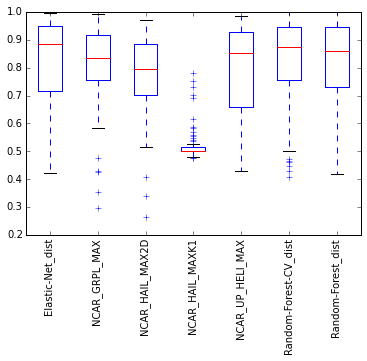

In [103]:
roc_keys = sorted(all_roc_scores.keys())
auc_values = [[c.auc() for c in all_roc_scores[r]] for r in roc_keys]
plt.boxplot(auc_values)
plt.xticks(np.arange(1, len(roc_keys)+1), roc_keys, rotation=90)

In [101]:
for k, s in all_roc_scores.iteritems():
    bs = bootstrap(s)
    b_aucs = np.array([x.auc() for x in bs])
    print k, np.percentile(b_aucs, 5), np.percentile(b_aucs, 50), np.percentile(b_aucs, 95)

KeyboardInterrupt: 

In [113]:
pcurves = []
rcurves = [] 
for k in roc_keys:
    bs = bootstrap(all_roc_scores[k])
    pcurves.append(np.dstack([x.performance_curve().values for x in bs]))
    rcurves.append(np.dstack([x.roc_curve().values for x in bs]))

In [114]:
def bs_roc(rcurves, roc_objs, obj_labels, colors, markers, filename, figsize=(8, 8), xlabel="Success Ratio (1-FAR)",
                           ylabel="Probability of Detection", ticks=np.arange(0, 1.1, 0.1), dpi=300, csi_cmap="Blues",
                           csi_label="Critical Success Index", title="Performance Diagram",
                           legend_params=dict(loc=0, fontsize=10, framealpha=1, frameon=True)):
    plt.figure(figsize=figsize)
    plt.plot(ticks, ticks, "k--")
    if rcurves is not None:
        for b, broc_curves in enumerate(rcurves):
            pod_range = np.percentile(broc_curves[:,0], [2.5, 97.5], axis=1)
            pofd_range = np.percentile(broc_curves[:, 1], [2.5, 97.5], axis=1)
            pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
            pofd_poly = np.concatenate((pofd_range[0], pofd_range[1, ::-1]))
            pod_poly[np.isnan(pod_poly)] = 0
            pofd_poly[np.isnan(pofd_poly)] = 0
            plt.fill(pofd_poly, pod_poly, alpha=0.5, color=colors[b])
    for r, roc_obj in enumerate(roc_objs):
        roc_data = roc_obj.roc_curve()
        plt.plot(roc_data["POFD"], roc_data["POD"], marker=markers[r], color=colors[r], 
                 label=obj_labels[r] + " ({0:0.3f})".format(roc_obj.auc()))
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks, fontsize=12)
    plt.yticks(ticks, fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend(**legend_params)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close()


def bs_performance_diagram(pcurves, roc_objs, obj_labels, colors, markers, filename, figsize=(8, 8), xlabel="Success Ratio (1-FAR)",
                           ylabel="Probability of Detection", ticks=np.arange(0, 1.1, 0.1), dpi=300, csi_cmap="Blues",
                           csi_label="Critical Success Index", title="Performance Diagram",
                           legend_params=dict(loc=0, fontsize=10, framealpha=1, frameon=True)):
    csi_cmap = "Blues"
    plt.figure(figsize=figsize)
    grid_ticks = np.arange(0, 1.01, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, [0,0.05]  + np.arange(0.1, 1.1, 0.1).tolist(), extend="max", cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [0.5, 1, 1.5, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.1f", manual=[(0.2, 0.9), (0.4, 0.9), (0.6, 0.9), (0.7, 0.7), (0.8, 0.4)])
    for i, c in enumerate(pcurves):
        pod_range = np.percentile(c[:,0], [2.5, 97.5], axis=1)
        sr_range = np.percentile(1-c[:,1], [2.5, 97.5], axis=1)
        pod_poly = np.concatenate((pod_range[1], pod_range[0, ::-1]))
        sr_poly = np.concatenate((sr_range[1], sr_range[0, ::-1]))
        pod_poly[np.isnan(pod_poly)] = 0
        sr_poly[np.isnan(sr_poly)] = 1
        plt.fill(sr_poly, pod_poly, alpha=0.5, color=colors[i])
    for r, roc_obj in enumerate(roc_objs):
        perf_data = roc_obj.performance_curve()
        plt.plot(1 - perf_data["FAR"], perf_data["POD"], marker=markers[r], color=colors[r], 
                 label=obj_labels[r].replace("_dist", "").replace("-", " ").replace("_", " ") 
                 + " ({0:0.3f})".format(roc_obj.max_csi()))
    cbar = plt.colorbar(csi_contour)
    cbar.set_label(csi_label, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks, fontsize=12)
    plt.yticks(ticks, fontsize=12)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.text(0.48,0.6,"Frequency Bias",fontdict=dict(fontsize=16, rotation=45))
    plt.legend(**legend_params)
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    plt.close()

bs_roc(rcurves, roc_vals, roc_labels, ['r','g','orange', 'b', "purple"], ['o'] *5, 
       "/sharp/djgagne/hail_figures_ams2016/roc_bs_ncar_{0:d}_{1}.pdf".format(size_threshold[0], neighbor_radius), 
        title="24-Hour {1} km Neighbor Prob. of {0:d} mm Hail".format(size_threshold[0], neighbor_radius * 3))
bs_performance_diagram(pcurves, roc_vals, roc_labels, ['r','g','orange', 'b', "purple"], ['o'] *5, 
                    "/sharp/djgagne/hail_figures_ams2016/perf_bs_ncar_{0:d}_{1}.pdf".format(size_threshold[0], neighbor_radius), 
                    title="24-Hour {1} km Neighbor Prob. of {0:d} mm Hail".format(size_threshold[0], neighbor_radius * 3))

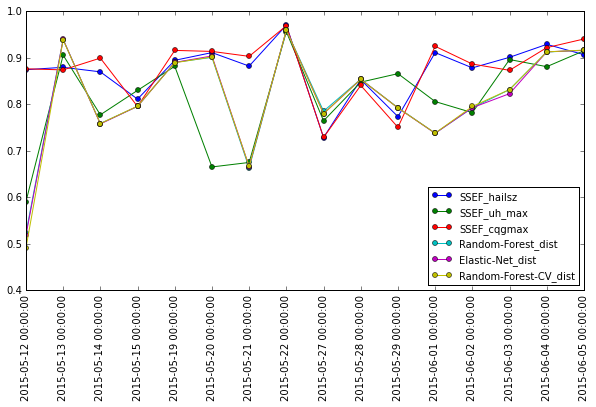

In [18]:
plt.figure(figsize=(10,5))
for k, s in all_roc_scores.iteritems():
    plt.plot(np.arange(len(s.index)), [x.auc() for x in s], marker='o', markersize=5, label=k)
    plt.xticks(np.arange(len(s)), s.index, rotation=90)
plt.legend(loc=0, fontsize=10)
#plt.ylim(0.75, 0.9)

In [213]:
all_roc_scores["Random-Forest-CV_dist"][0]

0.49615070361557168

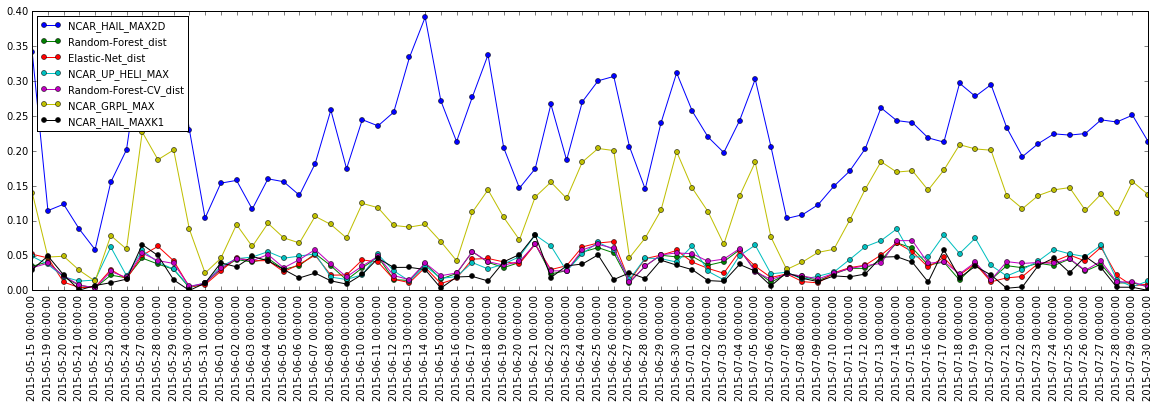

In [129]:
plt.figure(figsize=(20,5))
for k, s in all_rel_scores.iteritems():
    plt.plot(np.arange(len(s.index)), [x.brier_score() for x in s], marker='o', markersize=5, label=k)
    plt.xticks(np.arange(len(s.index)), s.index, rotation=90)
plt.legend(loc=0, fontsize=10)
#plt.ylim(0.75, 0.9)

In [139]:
rf_aucs = np.array([x.brier_score_components() for x in all_rel_scores["Random-Forest-CV_dist"]])
uh_aucs = np.array([x.brier_score_components() for x in all_rel_scores["NCAR_UP_HELI_MAX"]])
print uh_aucs
print np.count_nonzero(rf_aucs >= uh_aucs)
print np.count_nonzero(rf_aucs < uh_aucs)
plt.scatter(uh_aucs, rf_aucs)
#plt.plot(np.arange(0.3, 1.1, 0.1), np.arange(0.3, 1.1, 0.1), 'k--')

ZeroDivisionError: float division by zero

In [153]:
for f in all_rel_scores["Random-Forest-CV_dist"]:
    print f.frequencies["Total_Freq"].sum()

991983
990878
989008
987202
987732
996134
999113
1000539
1000465
1007632
1010849
1011234
1011929
1013421
1013732
1014949
1015122
1008562
1012108
1007722
1007203
998778
1005445
1006719
0
951324
949760
944418
940678
949769
946658
58909
933557
948502
965497
959695
0
0
971699
974910
970218
961801
957442
959971
936133
945317
945698
945424
941970
0
0
990625
987966
980185
973083
964065
0
989284
998235
1011100
1015084
1015917
1022387
1015859
1009935
1009509
1007307
1000295
995740
989029
981668
977782
974967
969956
0
0
943689
933902
932720
939149
933297
933403
943774
954385
972397
994412
999185
1001237
1007140
916278
1005492
997775
1000271
993488
995554
993540
991404
985122
985864
0
0
967158
964420
963129
962297
968104
965514
966377
974655
981730
981180
0
988244
989719
988190
991944
989478
987470
987312
985853
980380
970860
978024
975453
0
0
978790
979971
979504
986591
989217
999221
1009602
1010844
1012851
1012784
1022061
1024586
1027895
1028589
1023895
1019293
1029076
1018824
1024702
1024509
1

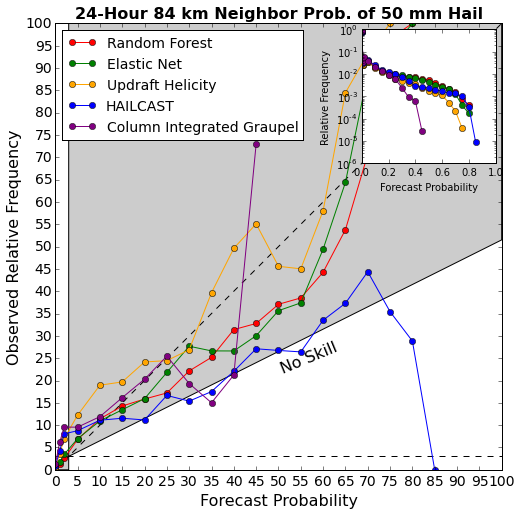

In [200]:
attributes_diagram(rel_vals, roc_labels,['r','g','orange', 'b', "purple", "brown", "gold"], ['o'] *7,
                   '/sharp/djgagne/hail_figures_ams2016/attr_period_ssef_{0}.png'.format(size_threshold[0]), 
                   title="24-Hour {1} km Neighbor Prob. of {0} mm Hail".format(size_threshold[0], neighbor_radius * 3))

In [187]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

def attributes_diagram(rel_objs, obj_labels, colors, markers, filename, figsize=(8, 8), xlabel="Forecast Probability",
                        ylabel="Observed Relative Frequency", ticks=np.arange(0, 1.05, 0.05), dpi=300, inset_size="30%",
                        title="Attributes Diagram",
                        legend_params=dict(loc=0, fontsize=14, framealpha=1, frameon=True)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.plot(ticks, ticks, "k--")
    inset_hist = inset_axes(ax, width=inset_size, height=inset_size, loc=1, axes_kwargs=dict(axisbg='white'))
    climo = rel_objs[0].climatology()
    no_skill = 0.5 * ticks + 0.5 * climo
    skill_x = [climo, climo, 1, 1, climo, climo, 0, 0, climo]
    skill_y = [climo, 1, 1, no_skill[-1], climo, 0, 0, no_skill[0], climo]
    ax.fill(skill_x, skill_y, "0.8")
    ax.plot(ticks, np.ones(ticks.shape) * climo, "k--")
    for r, rel_obj in enumerate(rel_objs):
        rel_curve = rel_obj.reliability_curve()
        ax.plot(rel_curve["Bin_Start"], rel_curve["Positive_Relative_Freq"], color=colors[r], marker=markers[r],
                 label=obj_labels[r].split("_")[0])
        inset_hist.semilogy(rel_curve["Bin_Start"], rel_curve["Total_Relative_Freq"], color=colors[r],
                            marker=markers[r])
    inset_hist.set_xlabel("Forecast Probability")
    inset_hist.set_ylabel("Relative Frequency")
    ax.annotate("No Skill", (ticks[ticks.size / 2], no_skill[ticks.size / 2]), 
                rotation=22.5, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xticks(ticks)
    ax.set_xticklabels((ticks * 100).astype(int), fontsize=14)
    ax.set_yticks(ticks)
    ax.set_yticklabels((ticks * 100).astype(int), fontsize=14)
    ax.set_xlim(ticks.min(), ticks.max())
    ax.set_ylim(ticks.min(), ticks.max())
    ax.legend(**legend_params)
    ax.set_title(title, fontsize=16, fontweight="bold")
    plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    #plt.close()

In [130]:
hour_eval = pd.read_csv("/sharp/djgagne/neighbor_scores_ssef_unique_2015/ssef_uh_neighbor_hour_scores.csv",  parse_dates=["Run_Date"])
hour_eval = pd.read_csv("/sharp/djgagne/neighbor_scores_ncar_2015/ncar_2015_neighbor_series_hour_scores.csv")
#period_eval = pd.read_csv("/sharp/djgagne/neighbor_scores_ncar_2015/ncar_2015_period_scores.csv")
hour_eval = hour_eval.drop(np.where(np.in1d(hour_eval['Run_Date'].values, 
                 [np.datetime64('2015-05-23'), np.datetime64('2015-05-24'), np.datetime64('2015-05-30'),
                 np.datetime64('2015-05-31')]))[0])
print hour_eval.shape

(100800, 10)


In [154]:
hour_eval

,Index,Run_Date,Forecast_Hour,Model_Name,Forecast_Variable,Neighbor_Radius,Smoothing_Radius,Size_Threshold,ROC,Reliability
0,neighbor_prob_r_14_s_5_dist_25.00_12,2015-05-15,12,Elastic-Net,dist,14,5,25,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
1,neighbor_prob_r_14_s_20_dist_25.00_12,2015-05-15,12,Elastic-Net,dist,14,20,25,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
2,neighbor_prob_r_14_s_5_dist_50.00_12,2015-05-15,12,Elastic-Net,dist,14,5,50,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
3,neighbor_prob_r_14_s_20_dist_50.00_12,2015-05-15,12,Elastic-Net,dist,14,20,50,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
4,neighbor_prob_r_28_s_5_dist_25.00_12,2015-05-15,12,Elastic-Net,dist,28,5,25,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
5,neighbor_prob_r_28_s_20_dist_25.00_12,2015-05-15,12,Elastic-Net,dist,28,20,25,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
6,neighbor_prob_r_28_s_5_dist_50.00_12,2015-05-15,12,Elastic-Net,dist,28,5,50,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
7,neighbor_prob_r_28_s_20_dist_50.00_12,2015-05-15,12,Elastic-Net,dist,28,20,50,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
8,neighbor_prob_r_14_s_5_dist_25.00_13,2015-05-15,13,Elastic-Net,dist,14,5,25,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...
9,neighbor_prob_r_14_s_20_dist_25.00_13,2015-05-15,13,Elastic-Net,dist,14,20,25,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...,Obs_Threshold:0.50;Thresholds:0.00 0.01 0.02 0...


In [157]:
model_col = hour_eval["Model_Name"]  + "_" + hour_eval["Forecast_Variable"]
all_models = pd.unique(model_col)
forecast_hours = np.sort(pd.unique(hour_eval["Forecast_Hour"]))
print all_models
smoothing_radius = 20
size_threshold = [50, 150, 40]
neighbor_radius = 28

roc_scores = {}
all_roc_scores = {}
rel_scores = {}
all_rel_scores = {}
hour_scores = pd.DataFrame(index=np.arange(len(all_models) * len(forecast_hours)), 
                           columns=["Model", "Forecast_Hour", "ROC", "Reliability"])
hi = 0
for model in all_models:
    print model
    for hour in forecast_hours:
        idxs = (model_col == model) &\
               (hour_eval["Smoothing_Radius"]==smoothing_radius) &\
               (hour_eval["Size_Threshold"].isin(size_threshold)) &\
               (hour_eval["Neighbor_Radius"] == neighbor_radius) &\
               (hour_eval["Forecast_Hour"] == hour)
        if np.count_nonzero(idxs) > 0:
            roc = pd.Series([DistributedROC(input_str=x) for x in hour_eval.loc[idxs, "ROC"]], 
                        index=hour_eval.loc[idxs, "Index"])
            rel = pd.Series([DistributedReliability(input_str=x) for x in hour_eval.loc[idxs, "Reliability"]],
                        index=hour_eval.loc[idxs, "Index"])
            hour_scores.loc[hi] = [model, hour, np.sum(roc), np.sum(rel)]
            hi += 1
        #roc_scores[model] = np.sum(roc)
        #rel_scores[model] = np.sum(rel)
        #all_roc_scores[model] = roc
        #all_rel_scores[model] = rel
        #print model, roc_scores[model].auc(), rel_scores[model].brier_skill_score()

['Elastic-Net_dist' 'NCAR_GRPL_MAX' 'NCAR_UP_HELI_MAX'
 'Random-Forest-CV_dist' 'NCAR_HAIL_MAXK1' 'Random-Forest_dist'
 'NCAR_HAIL_MAX2D']
Elastic-Net_dist
NCAR_GRPL_MAX
NCAR_UP_HELI_MAX
Random-Forest-CV_dist
NCAR_HAIL_MAXK1
Random-Forest_dist
NCAR_HAIL_MAX2D


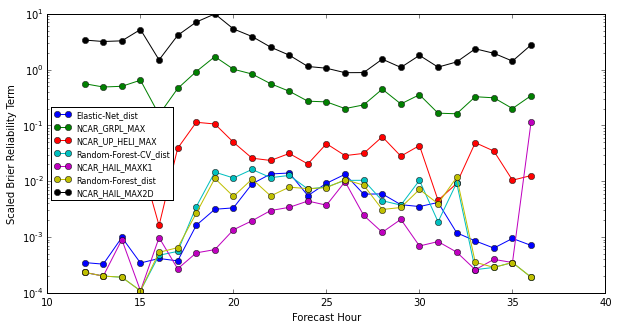

In [193]:
plt.figure(figsize=(10, 5))
for model in all_models:
    aucs = [x.auc() for x in hour_scores.loc[hour_scores["Model"]==model,"ROC"]]
    bss = [x.brier_score_components()[0]/x.brier_score_components()[2] for x in hour_scores.loc[hour_scores["Model"]==model,"Reliability"]]
    pos_freqs = np.array([x.frequencies["Positive_Freq"].sum() 
                          for x in hour_scores.loc[hour_scores["Model"]==model,"Reliability"]])
    freqs = np.array([x.frequencies["Total_Freq"].sum() 
                      for x in hour_scores.loc[hour_scores["Model"]==model,"Reliability"]], dtype=float)

    hours = hour_scores.loc[hour_scores["Model"]==model, "Forecast_Hour"]
    plt.semilogy(hours, bss, marker='o', label=model)
    #plt.plot(hours, aucs, marker='o', label=model)
    #plt.plot(hours, pos_freqs/ freqs * 100, marker='o')
plt.legend(fontsize=8, loc=0)
plt.xlabel("Forecast Hour")
plt.ylabel("Scaled Brier Reliability Term")
#plt.ylim(0, 0.1)

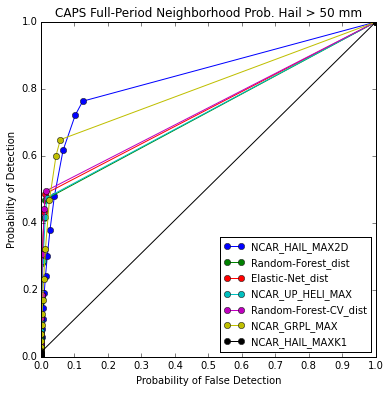

In [133]:
plt.figure(figsize=(6,6))
for model, score in roc_scores.iteritems():
    rc = score.roc_curve()
    plt.plot(rc["POFD"], rc["POD"], marker='o', label=model)
plt.xlim(0,1)
plt.legend(loc=0, fontsize=10)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlabel("Probability of False Detection")
plt.ylabel("Probability of Detection")
plt.title("CAPS Full-Period Neighborhood Prob. Hail > {0:d} mm".format(size_threshold[0]))
#plt.savefig("/sharp/djgagne/neighbor_scores_ssef_unique_2015/roc_hour_ssef_2015.png", dpi=300, bbox_inches="tight")

In [135]:
attributes_diagram(rel_scores.values(), rel_scores.keys(),['r','g','b','orange', "purple", "tan", "gold"], ['o'] *7,
                   '/sharp/djgagne/hail_figures_ams2016/attr_hour_ncar.png', ticks=np.arange(0, 1.0, 0.05))

In [356]:
storm_variables=["uh_max", "r10cmx", "wupmax", "cqgmax", "wdnmax"]
potential_variables=["mlcape", "mlcins", "sblcl", "srh03", "shr06",
                                   "dewp2m", "temp2m", "sph850", "sph500", "lllr", "lr75"]
shape_variables = ["area", "eccentricity", "major_axis_length", "minor_axis_length", "orientation",
                   "extent"] + ["weighted_moments_hu_{0:d}".format(h) for h in range(7)]
variable_statistics=["mean", "max", "min", "std", "mean_dt", "max_dt"]
input_columns = ["Forecast_Hour", "Valid_Hour_UTC", "Duration_Step", "Duration_Total", "Centroid_Lon", "Centroid_Lat"]
for var in storm_variables + potential_variables:
    for stat in variable_statistics:
        input_columns.append(var + "_" + stat)
input_columns += shape_variables


In [413]:
storm_variables = ["Updraft Helicity", "Reflectivity -10C", "Updraft Speed", "Graupel Mass", "Downdraft Speed"]
potential_variables = ["MLCAPE", 'MLCIN', "LCL", "0-3 km SR Helicity", "0-6 km Shear",
                       "Dewpoint 2 m", "Temperature 2 m", "Sp. Humidity 850 mb", "Sp. Humidity 500 mb",
                       "Low-Level Lapse Rate", "Mid-Level Lapse Rate"]
shape_variables = ["Area", "Eccentricity", "Major Axis Length", "Minor Axis Length", "Orientation",
                  "Extent",] + ["Weighted Hu Moments {0:d}".format(h) for h in range(7)]
variable_statistics = ["Mean", "Max", "Min", "SD", "Mean DT", "Max DT"]
input_columns = ["Forecast Hour", "Valid Hour UTC", "Duration Step", 
                 "Duration Total", "Centroid Longitude", "Centroid Latitude"]
for var in storm_variables + potential_variables:
    for stat in variable_statistics:
        input_columns.append(var + " " + stat)
input_columns += shape_variables

In [126]:
condition_files = sorted(glob("/sharp/djgagne/track_models_cqg_closest_spring2015/*_condition.pkl"))
condition_models = {}
for condition_file in condition_files:
    mp = condition_file.split("/")[-1].split("_")[0]
    if mp != "WDM6":
        c_file = open(condition_file)
        condition_models[mp] = cPickle.load(c_file)
        c_file.close()

In [127]:
importances = np.zeros((len(input_columns), len(condition_models)))
m = 0
for mp, cond_model in condition_models.iteritems():
    importances[:, m] = cond_model.best_estimator_.feature_importances_
    m += 1

NameError: name 'input_columns' is not defined

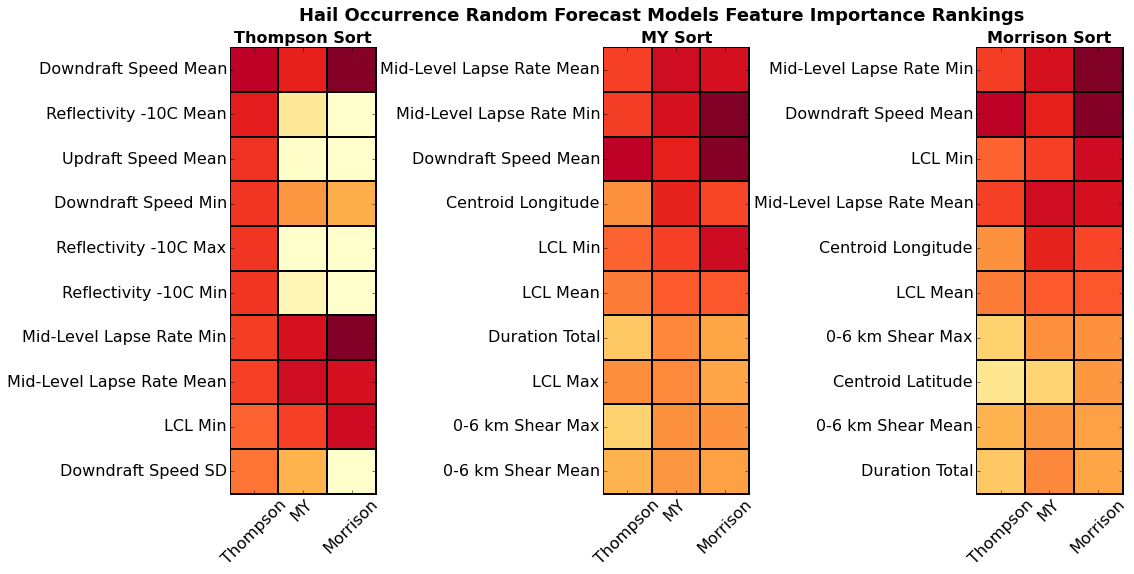

In [546]:
plt.figure(figsize=(16, 8))
plt.subplots_adjust(wspace=1.55)
for i in range(1, importances.shape[1]+1):
    plt.subplot(1, importances.shape[1], i)
    ranks = importances[:,i-1].argsort()
    plt.pcolormesh(np.log(importances[ranks]), vmax=-2, vmin=-5, cmap=plt.get_cmap("YlOrRd"),
                  edgecolors='k')
    #if i == importances.shape[1]:
    #    cbar = plt.colorbar()
    #    cbar.set_label("ln(Importance Score)", fontsize=18)
    input_columns = np.array(input_columns)
    yt = plt.yticks(np.arange(0.5,len(input_columns)),input_columns[ranks], fontsize=16)
    xt = plt.xticks(np.arange(0.5, len(condition_models)), condition_models.keys(), fontsize=16, rotation=45)
    plt.ylim(len(input_columns)- 10, len(input_columns))
    plt.title(condition_models.keys()[i-1] + " Sort", fontsize=16, fontweight="bold")
plt.suptitle("Hail Occurrence Random Forecast Models Feature Importance Rankings", 
             fontsize=18, fontweight="bold", y=0.97)
plt.savefig("/sharp/djgagne/hail_figures_spring2015/rf_importances_condition.png", bbox_inches="tight", dpi=300)

In [443]:
rf_model_obj = condition_models["Thompson"].best_estimator_

In [447]:
for i in range(len(rf_model_obj.estimators_)):
    print i,
    export_graphviz(rf_model_obj.estimators_[i], out_file="/sharp/djgagne/rf_trees/tree{0:03d}.dot".format(i), feature_names=input_columns)

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 2

In [470]:
enet_model_obj = cPickle.load(open("/sharp/djgagne/track_models_unique_spring2015/Thompson_Elastic-Net_multi_sizedist.pkl"))


In [495]:
for c, coef in enumerate(enet_model_obj.coef_[2]):
    if coef > 0:
        print input_columns[c], coef

Forecast Hour 0.000128399862992
Centroid Longitude 0.00438339905452
Updraft Helicity Mean 0.000581859111358
Updraft Helicity Max 0.00167105140577
Updraft Helicity SD 0.00236775397264
Graupel Mass Max 0.000502361724848
Graupel Mass Min 0.000190969013116
MLCAPE Mean 0.000175885081069
MLCAPE SD 8.93436117428e-05
MLCAPE Mean DT 2.90167869981e-05
MLCIN Mean 0.000521650369513
MLCIN Min 0.000151207262199
MLCIN Max DT 0.000129165460341
LCL Mean 8.61416166982e-05
LCL Max 0.000524200404811
LCL Mean DT 6.4774714511e-05
0-3 km SR Helicity Max 0.000620795646636
0-3 km SR Helicity Mean DT 0.000413620458524
Sp. Humidity 850 mb Mean 1.60201170847e-05
Sp. Humidity 850 mb Min 1.87324264538e-05
Sp. Humidity 850 mb SD 1.73823997392e-05
Sp. Humidity 850 mb Max DT 4.44402069483e-05
Mid-Level Lapse Rate Min 0.000167571626721


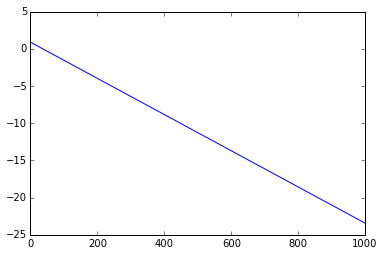

In [494]:
prod = np.dot(enet_model_obj.coef_[2].reshape((1,115)),
    np.tile(np.arange(0, 1000), 115).reshape(115, 1000))
vals = enet_model_obj.intercept_[2] + prod.sum(axis=0)
plt.plot(np.arange(1000), vals)

array([ -0.14689926,  -2.94514102,  -5.74338277,  -8.54162453,
       -11.33986629, -14.13810804, -16.9363498 , -19.73459156,
       -18.13926823,  -0.99853806,  -3.79677981,  -6.59502157,
        -9.39326333, -12.19150508, -14.98974684, -17.7879886 ,
       -20.58623035, -10.89488563,  -1.85017685,  -4.64841861,
        -7.44666036, -10.24490212, -13.04314388, -15.84138564,
       -18.63962739, -21.43786915,  -4.63591594,  -2.70181565,
        -5.5000574 ,  -8.29829916, -11.09654092, -13.89478267,
       -16.69302443, -19.49126619, -17.84396867,  -0.75521268,
        -3.55345444,  -6.3516962 ,  -9.14993796, -11.94817971,
       -14.74642147, -17.54466323, -20.34290498, -13.49257837,
        -1.60685148,  -4.40509324,  -7.20333499, -10.00157675,
       -12.79981851, -15.59806027, -18.39630202, -21.19454378,
       -12.77039311,  -2.45849028,  -5.25673203,  -8.05497379,
       -10.85321555, -13.6514573 , -16.44969906, -19.24794082,
       -17.6371951 ,  -0.51188731,  -3.31012907,  -6.10

In [21]:
period_eval

,Index,Run_Date,Model_Name,Forecast_Variable,Neighbor_Radius,Smoothing_Radius,Size_Threshold,ROC,Reliability
48,neighbor_prob_25-hour_r_14_s_5_dist_25.00,2015-05-15,Random-Forest-CV,dist,14,5,25,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...
49,neighbor_prob_25-hour_r_14_s_20_dist_25.00,2015-05-15,Random-Forest-CV,dist,14,20,25,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...
50,neighbor_prob_25-hour_r_14_s_5_dist_50.00,2015-05-15,Random-Forest-CV,dist,14,5,50,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...
51,neighbor_prob_25-hour_r_14_s_20_dist_50.00,2015-05-15,Random-Forest-CV,dist,14,20,50,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...
52,neighbor_prob_25-hour_r_28_s_5_dist_25.00,2015-05-15,Random-Forest-CV,dist,28,5,25,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...
53,neighbor_prob_25-hour_r_28_s_20_dist_25.00,2015-05-15,Random-Forest-CV,dist,28,20,25,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...
54,neighbor_prob_25-hour_r_28_s_5_dist_50.00,2015-05-15,Random-Forest-CV,dist,28,5,50,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...
55,neighbor_prob_25-hour_r_28_s_20_dist_50.00,2015-05-15,Random-Forest-CV,dist,28,20,50,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...
56,neighbor_prob_25-hour_r_14_s_5_dist_25.00,2015-05-15,Elastic-Net,dist,14,5,25,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...
57,neighbor_prob_25-hour_r_14_s_20_dist_25.00,2015-05-15,Elastic-Net,dist,14,20,25,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...,Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0...


In [44]:
roc["2015-06-04"]

Obs_Threshold:0.50;Thresholds:0.00 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75 0.80 0.85 0.90 0.95 1.00 1.05;TP:0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;FP:336624 120769 97741 82000 65739 49620 45521 41408 37285 33171 29061 24473 19406 12479 0 0 0 0 0 0 0 0;FN:0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0;TN:0 215855 238883 254624 270885 287004 291103 295216 299339 303453 307563 312151 317218 324145 336624 336624 336624 336624 336624 336624 336624 336624

In [40]:
object_eval_file = "/sharp/djgagne/evaluation_data_spring2015_cqg_closest/object_scores_ssef_2015_cqg_closest_dist.csv"
object_eval_data = pd.read_csv(object_eval_file)
print object_eval_data.shape
for col in object_eval_data.columns:
    if "ROC" in col:
        object_eval_data[col] = [DistributedROC(input_str=x) for x in object_eval_data[col]]
    elif "Rel" in col:
        object_eval_data[col] = [DistributedReliability(input_str=x) for x in object_eval_data[col]]
    elif "CRPS" in col:
        object_eval_data[col] = [DistributedCRPS(input_str=x) for x in object_eval_data[col]]
    

(16050, 15)


KeyboardInterrupt: 

In [3]:
crps = object_eval_data["CRPS"].sum()

In [114]:
members = object_eval_data["Ensemble_Member"].unique()
models = object_eval_data["Model_Name"].unique()
for member in members:
    for model in models:
        sub_data = object_eval_data.loc[(object_eval_data["Model_Name"]==model) & 
                                        (object_eval_data["Ensemble_Member"]==member) & 
                                        (object_eval_data["Forecast_Hour"] > 18) &
                                        (object_eval_data["Forecast_Hour"] < 30) &
                                        (object_eval_data["Run_Date"] > "2015-05-25 00:00:00")]
        crps = sub_data["CRPS"].sum()
        crps_max = sub_data["CRPS_Max"].sum()
        rel = sub_data["Rel_25"].sum()
        print member, model, crps.crps(), crps.crpss(), crps.crps_climo(), crps_max.crpss()

wrf-s3cn_arw Random Forest 0.040714057971 -1.67575170124 0.0152159327609 -0.248315209343
wrf-s3cn_arw Elastic Net 0.0399267306053 -1.6240080863 0.0152159327609 -0.233883214567
wrf-s3cn_arw Random Forest CV 0.0406421952259 -1.67102883961 0.0152159327609 -0.246365353768
wrf-s3m12_arw Random Forest 0.0390654125413 -1.54442197949 0.0153533544578 -0.354338814714
wrf-s3m12_arw Elastic Net 0.038091320132 -1.48097705533 0.0153533544578 -0.335331551588
wrf-s3m12_arw Random Forest CV 0.0389704125413 -1.53823440659 0.0153533544578 -0.355121455484
wrf-s3m11_arw Random Forest 0.0410909381044 -1.67947824948 0.0153354251382 -0.305089951095
wrf-s3m11_arw Elastic Net 0.0401072485493 -1.61533333362 0.0153354251382 -0.279685140603
wrf-s3m11_arw Random Forest CV 0.0409420357834 -1.66976855316 0.0153354251382 -0.306552274003
wrf-s3m3_arw Random Forest 0.0376952279874 -1.48399568293 0.0151752389291 -0.410818481975
wrf-s3m3_arw Elastic Net 0.0368423761792 -1.42779546018 0.0151752389291 -0.412526406721
wrf-s3

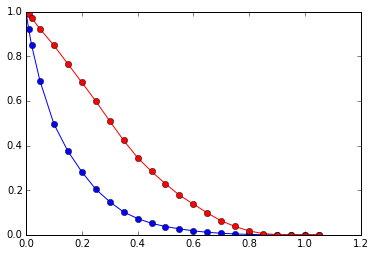

In [74]:
roc_curve = roc.roc_curve()
plt.plot(roc.thresholds, roc_curve["POFD"], 'bo-')
plt.plot(roc.thresholds, roc_curve["POD"], 'ro-')

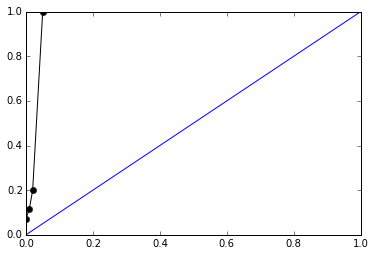

In [111]:
rel_curve = rel.reliability_curve()
plt.plot(rel_curve["Bin_Start"], rel_curve["Positive_Relative_Freq"], 'ko-')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1))

(0, 200)

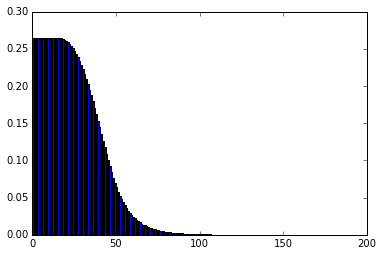

In [110]:
plt.bar(crps_max.thresholds, (crps_max.errors["F_2"] - 2 * crps_max.errors["F_O"] + crps_max.errors["O_2"]) / crps_max.num_forecasts )
plt.xlim(0, 200)

In [119]:
crps.errors


,F_2,F_O,O_2,O
0,876.000,174.000,4423.000,4423.000
1,876.000,174.000,4423.000,4423.000
2,876.000,174.000,4423.000,4423.000
3,876.000,174.000,4423.000,4423.000
4,876.000,174.000,4423.000,4423.000
5,876.000,174.000,4423.000,4423.000
6,876.000,174.335,4423.003,4424.096
7,879.224,295.884,4433.913,4544.732
8,941.814,734.398,4484.631,4756.217
9,1091.837,1211.187,4577.630,4975.875


In [211]:
condition_eval_file = "/sharp/djgagne/evaluation_data_spring2015_cqg_closest/object_scores_ssef_2015_cqg_closest_condition.csv"
condition_eval_data = pd.read_csv(condition_eval_file)
print condition_eval_data.shape
for col in condition_eval_data.columns:
    if "ROC" in col:
        condition_eval_data[col] = [DistributedROC(input_str=x) for x in condition_eval_data[col]]
    elif "Rel" in col:
        condition_eval_data[col] = [DistributedReliability(input_str=x) for x in condition_eval_data[col]]

(5350, 9)


In [214]:
cond_rocs = {}
cond_rels = {}
for member in members:
    cond_data = condition_eval_data.loc[condition_eval_data["Ensemble_Member"] == member]
    cond_rocs[member] = cond_data["ROC_0"].sum()
    cond_rels[member] = cond_data["Rel_0"].sum()
    print member, cond_rocs[member].auc(), cond_rels[member].brier_skill_score()

 wrf-s3cn_arw 0.697272218819 0.0426612927723
wrf-s3m12_arw 0.686112161948 0.0460684718825
wrf-s3m11_arw 0.715389701013 0.0912632370701
wrf-s3m3_arw 0.765333171561 0.0776683862449
wrf-s3m7_arw 0.790094517047 0.161853968878
wrf-s3m8_arw 0.738973564075 0.043250776567
wrf-s3m9_arw 0.753775760413 0.0693844047747
wrf-s3m4_arw 0.766583751314 0.122559211247
wrf-s3m5_arw 0.786535750765 0.145219064725
wrf-s3m6_arw 0.758614049086 0.11047657975
wrf-s3m10_arw 0.793454619571 0.162863606509
wrf-s3m13_arw 0.765327027352 0.12794960938


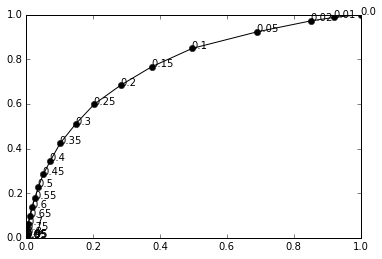

In [109]:
rc = roc.roc_curve()
plt.plot(rc["POFD"], rc["POD"], 'ko-')
for t in range(len(roc.thresholds)):
    plt.text(rc["POFD"][t], rc["POD"][t], roc.thresholds[t])

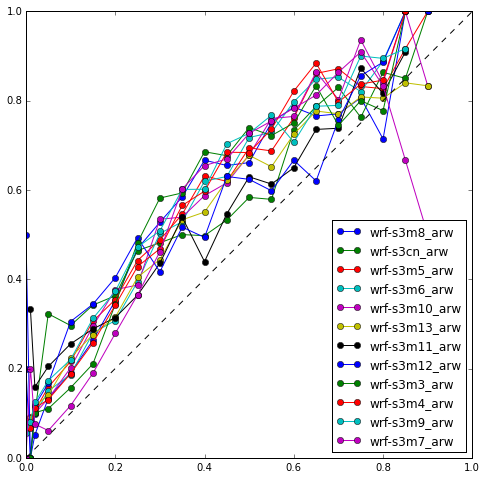

In [92]:
plt.figure(figsize=(8, 8))
for mem, relm in cond_rels.iteritems():
    relc = relm.reliability_curve()
    plt.plot(relc["Bin_Start"], relc["Positive_Relative_Freq"], label=mem, marker='o')
plt.plot(np.arange(0, 1.1, 0.1),
         np.arange(0, 1.1, 0.1), 'k--')
plt.legend(loc=0)

In [59]:
test_str = "Obs_Threshold:1.00;Thresholds:0.00 0.01 0.02 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75 0.80 0.85 0.90 0.95 1.00 1.05;Total_Freq:5 2 5 2 5 7 9 8 5 4 8 4 4 5 5 7 5 4 3 0 0 0 0 0;Positive_Freq:260 104 260 104 260 364 468 416 260 208 416 208 208 260 260 364 260 208 156 0 0 0 0 0"
dr = DistributedReliability(input_str=test_str)

In [71]:
g_samp = np.sort(gamma.rvs(2,6,10, size=(1000, 100)),axis=1)

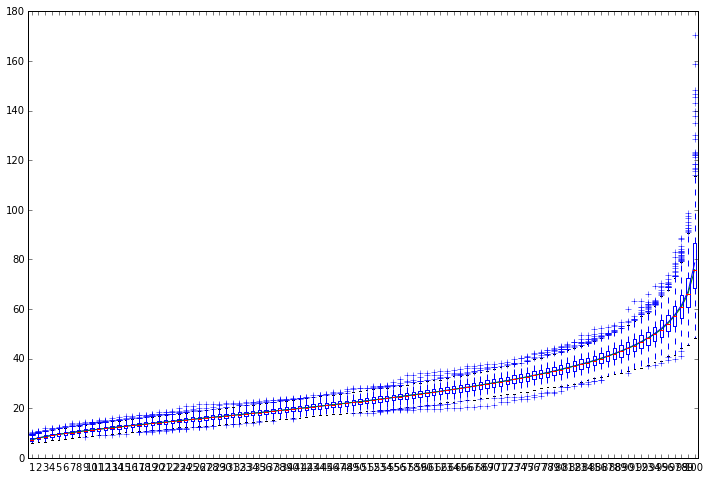

In [72]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, 101), g_samp.mean(axis=0))
plt.plot(np.arange(1, 101), np.median(g_samp, axis=0))
bpm = plt.boxplot(g_samp)

(array([  12.,   58.,  126.,  203.,  186.,  143.,   98.,   72.,   45.,
          26.,   10.,    5.,    5.,    2.,    3.,    2.,    2.,    0.,
           1.,    1.]),
 array([  48.41209445,   54.52511865,   60.63814285,   66.75116704,
          72.86419124,   78.97721544,   85.09023963,   91.20326383,
          97.31628803,  103.42931222,  109.54233642,  115.65536062,
         121.76838481,  127.88140901,  133.99443321,  140.1074574 ,
         146.2204816 ,  152.3335058 ,  158.44652999,  164.55955419,
         170.67257839]),
 <a list of 20 Patch objects>)

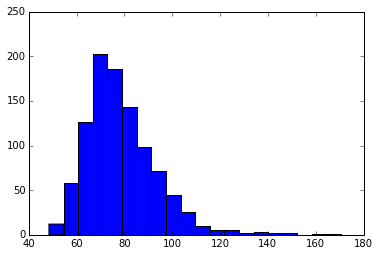

In [80]:
plt.hist(g_samp[:, 99], 20)

In [85]:
from scipy.stats import skew, kurtosis
kurtosis(g_samp[:,99])

3.8381067042558143

In [77]:
gamma.ppf(0.99, 2,6,10)

72.383520679938101